In [1]:
%load_ext autoreload
%autoreload 2  

import numpy as np
import pandas as pd
import yfinance as yf
import functions as f
import matplotlib.pyplot as plt
import datetime as dt
import funcoes as f
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
pd.set_option('display.max_rows', 500)

In [2]:
periodos = 36
oos = 1

# stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date').iloc[ : , :16].drop('BOVA11.SA', axis='columns')
stock_prices = pd.read_csv('precos.csv', sep=';', index_col='Date').drop('BOVA11.SA', axis='columns')

In [3]:
def weight_pca(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp/ pca_comp.sum()
    
    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normalize to sum to 1
    return res

def weight_eigen(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, S = np.linalg.eigh(cov_matrix)
    
    stats = f.summary_stats(pd.DataFrame(S),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = S[:,max_port] / np.sum(S[:,max_port]) # Normalize to sum to 1
    return res

Benchmark Done
EW Done
Eigen Done
PCA Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,0.06138,0.23088,0.26583,0.51528,-0.09643,-0.37652,-0.73058,6.24827,0.11067,0.14515
EW,0.14207,0.22759,0.62423,0.96959,-0.07193,-0.35372,-0.64933,6.44925,0.10128,0.13092
Eigen,0.19211,0.26095,0.73621,1.18782,-0.06823,-0.38053,-0.48887,5.92318,0.11141,0.14183
PCA,0.06394,0.29395,0.21750,0.53022,-0.11661,-0.45995,0.18244,6.68132,0.11952,0.17221


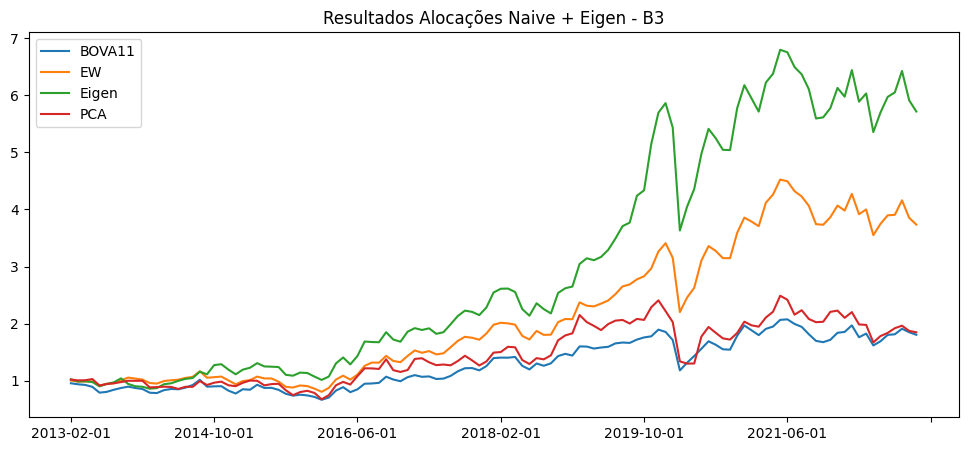

In [4]:
periodos = 36
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen = f.pipeline(stock_prices, periodos, oos, algo=weight_eigen);print('Eigen Done')
rets_pca = f.pipeline(stock_prices, periodos, oos, algo=weight_pca);print('PCA Done')


naive_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen": rets_eigen['rets'],
        "PCA": rets_pca['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(naive_portfolios_results, 0)

### LONG-ONLY

In [15]:
def weight_pca_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
        
    pca = PCA()
    pca_fitted = pca.fit(cov_matrix)
    
    pca_comp = pca_fitted.components_;
    pc_w = pca_comp
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res

def weight_eigen_long(df, cov_estimator=f.sample_cov, **kwargs):
    rets = (df - df.mean()) / df.std()
    cov_matrix = cov_estimator(rets)
    
    D, pc_w = np.linalg.eigh(cov_matrix)
    pc_w[pc_w < 0] = int(0.0001) ## tira os valores negativos, para ser long only

    stats = f.summary_stats(pd.DataFrame(pc_w),0).sort_values('Sharpe Ratio', ascending=False)
    max_port = stats.index[stats['Sharpe Ratio'] == stats['Sharpe Ratio'].max()][0]
    res = pc_w[:,max_port] / np.sum(pc_w[:,max_port]) # Normaliza para soma ser igual a 1 (evitar alavangcagem)
    return res
    
    
weight_eigen_long(f.returns(stock_prices).dropna()).dtype

dtype('float64')

Benchmark Done
EW Done
Eigen_long Done
PCA_long Done


,Annualized Return,Annualized Vol,Sharpe Ratio,Sortino Ratio,Average Drawdown,Max Drawdown,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%)
BOVA11,0.06138,0.23088,0.26583,0.51528,-0.09643,-0.37652,-0.73058,6.24827,0.11067,0.14515
EW,0.14207,0.22759,0.62423,0.96959,-0.07193,-0.35372,-0.64933,6.44925,0.10128,0.13092
Eigen Long,0.15291,0.24714,0.61872,0.98539,-0.07111,-0.37746,-0.60536,6.50881,0.10903,0.13975
PCA Long,0.14099,0.23086,0.61075,1.02468,-0.06908,-0.31997,-0.34816,5.30471,0.09920,0.13603


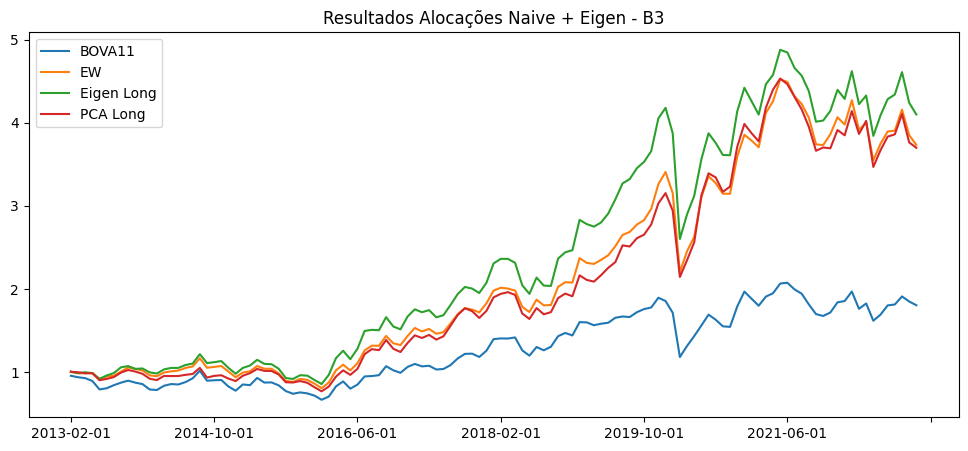

In [16]:
periodos = 36
oos = 1

bova = f.returns(pd.read_csv('precos.csv', sep=';', index_col='Date')['BOVA11.SA']);print('Benchmark Done')
rets_ew = f.pipeline(stock_prices, periodos, oos, algo=f.weight_ew);print('EW Done')
rets_eigen_long = f.pipeline(stock_prices, periodos, oos, algo=weight_eigen_long);print('Eigen_long Done')
rets_pca_long = f.pipeline(stock_prices, periodos, oos, algo=weight_pca_long);print('PCA_long Done')

naive_portfolios_results = pd.DataFrame(
    {
        "BOVA11": bova[rets_ew.index.min():],
        "EW": rets_ew['rets'],
        "Eigen Long": rets_eigen_long['rets'],
        "PCA Long": rets_pca_long['rets'],
    }
)

(1+naive_portfolios_results).cumprod().plot(figsize=(12,5), title="Resultados Alocações Naive + Eigen - B3");
f.summary_stats(naive_portfolios_results, 0)